This notebook performs clustering on taxi GPS data to identify key areas with high demand. Using MiniBatchKMeans for efficiency with large data, it finds cluster centers and assigns trips accordingly. Results will support demand prediction and resource planning.

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import MiniBatchKMeans
import folium
from folium.plugins import MarkerCluster
import pyproj
from pyproj import Transformer
from sklearn.metrics import silhouette_score
import os
import utm
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
from meteostat import Hourly, Stations

/Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Clustering

## 1. Loading the combined data-set

In [4]:
# Loading the combined dataframe 

# Path to the Pickle file
data_path = "../data/interim/combined_data.pkl"

# Loading the dataframe
combined_data = pd.read_pickle(data_path)

# Checking the data
print(f"Loaded dataset with {combined_data.shape[0]} rows and {combined_data.shape[1]} columns.")
print(combined_data.dtypes)
combined_data.head(3)

Loaded dataset with 4534327 rows and 4 columns.
messagetimestamp    datetime64[ns]
Lat                        float64
Lon                        float64
Base                        object
dtype: object


,messagetimestamp,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512


## 2. Converting the GPS coordinates to UTM

In [5]:
# Convert GPS coordinates (Lat, Lon) to UTM
# UTM provides coordinates in meters, 
# which is more suitable for distance-based algorithms like KMeans.
combined_data[['UTM_X', 'UTM_Y']] = combined_data.apply(
    lambda row: pd.Series(utm.from_latlon(row['Lat'], row['Lon'])[:2]),
    axis=1
)

In [6]:
# save the transformed data to avoid long running times
combined_data_with_utm = combined_data

# Path for saving the df
save_path = "../data/interim/combined_data_with_utm.pkl"

# safe the df
combined_data_with_utm.to_pickle(save_path)

## 3. Take a random sample to test different numbers of clusters

In [7]:
# Take a random sample to test different numbers of clusters
# Running KMeans on 4.5 million points for many values of k would be too slow.
# We sample 100,000 points for efficiency.
sample = combined_data[['UTM_X', 'UTM_Y']].sample(50000, random_state=42)

## 4. Find the optimal number of clusters

In [8]:
# Compute silhouette scores for different cluster numbers
# Silhouette Score helps to determine how well-separated the clusters are.
# A higher score indicates better clustering.
scores = []
K_range = range(10, 21)

for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=5000, random_state=42)
    labels = kmeans.fit_predict(sample)
    score = silhouette_score(sample, labels)
    scores.append(score)

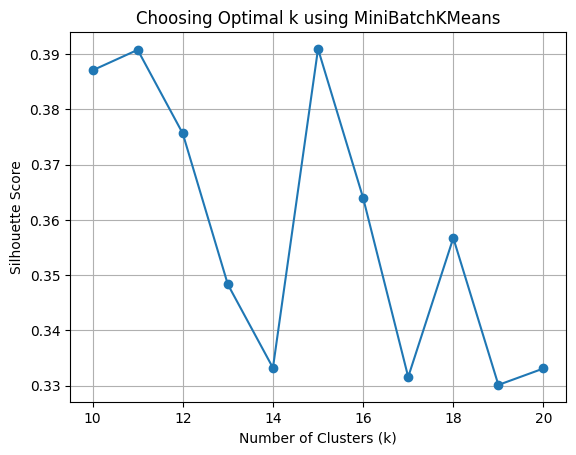

In [9]:
# Plot silhouette scores
plt.plot(K_range, scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Choosing Optimal k using MiniBatchKMeans')
plt.grid(True)
plt.show()

The number of clusters is set to 11, as it resulted in the highest silhouette score, indicating optimal cluster separation and cohesion. 

## 5. Clustering the full dataset with MiniBatchKmeans

In [10]:
# Run MiniBatchKMeans on the full dataset with the optimal number of clusters
optimal_k = 11
full_kmeans = MiniBatchKMeans(n_clusters=optimal_k, batch_size=10000, random_state=42)
combined_data['geo_cluster'] = full_kmeans.fit_predict(combined_data[['UTM_X', 'UTM_Y']])

In [11]:
combined_data.head(2)

,messagetimestamp,Lat,Lon,Base,UTM_X,UTM_Y,geo_cluster
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,588201.388855,4.513640e+06,2
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,581535.087804,4.508867e+06,0


## 6. Choosing the 10 most important clusters

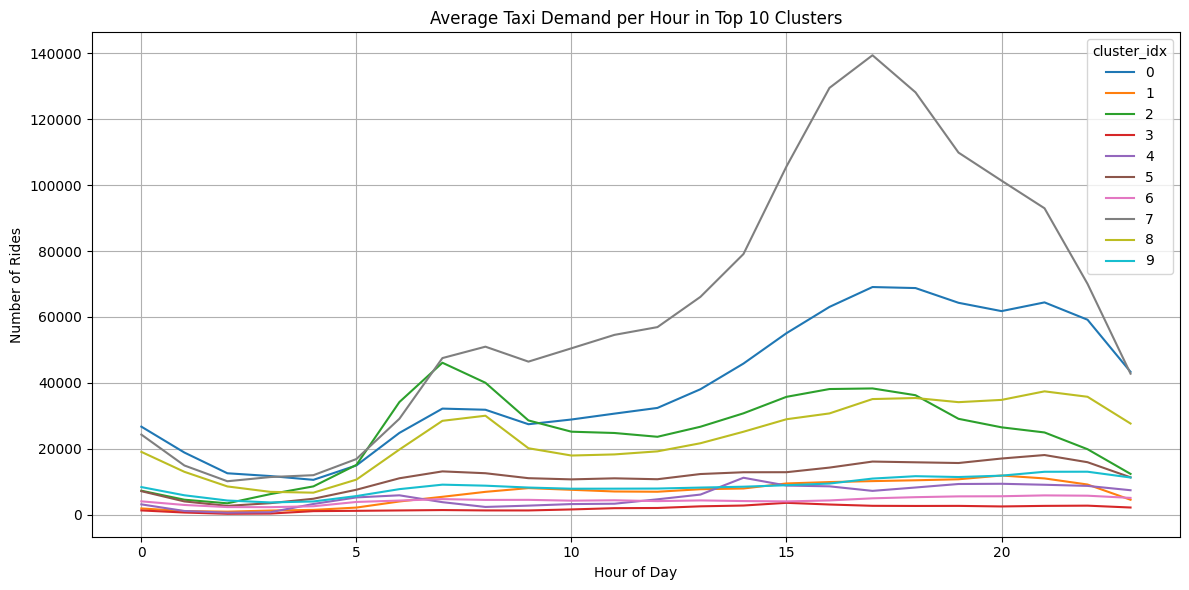

In [ ]:
# Identify top 10 clusters by number of rides
top_clusters = (
    combined_data['geo_cluster']
    .value_counts()
    .nlargest(10)
    .index
    .tolist()
)

# Filter dataset to include only these top clusters
top_combined_data = combined_data[combined_data['geo_cluster'].isin(top_clusters)].copy()

# Convert to datetime and extract hour
top_combined_data['messagetimestamp'] = pd.to_datetime(top_combined_data['messagetimestamp'])
top_combined_data['hour'] = top_combined_data['messagetimestamp'].dt.hour

# Remap cluster IDs to consecutive integers starting from 0
top_combined_data['cluster_idx'] = top_combined_data['geo_cluster'].astype('category').cat.codes

# Group by remapped cluster_idx and hour
hourly_counts = (
    top_combined_data.groupby(['cluster_idx', 'hour'])
    .size()
    .reset_index(name='rides_per_hour')
)

# Plot using remapped cluster_idx as hue
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_counts,
    x='hour',
    y='rides_per_hour',
    hue='cluster_idx',  
    palette='tab10'
)
plt.title('Average Taxi Demand per Hour in Top 10 Clusters')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.tight_layout()
plt.show()



In [13]:
top_combined_data.head(2)

,messagetimestamp,Lat,Lon,Base,UTM_X,UTM_Y,geo_cluster,hour,cluster_idx
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,588201.388855,4.513640e+06,2,0,2
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,581535.087804,4.508867e+06,0,0,0


In [14]:
# Drop the old 'geo_cluster' column
top_combined_data = top_combined_data.drop(columns=['geo_cluster'])

# Rename 'cluster_idx' to 'geo_cluster'
top_combined_data = top_combined_data.rename(columns={'cluster_idx': 'geo_cluster'})

In [15]:
counts_df = top_combined_data['geo_cluster'].value_counts().reset_index()
counts_df.columns = ['geo_cluster', 'count']
print(counts_df)

   geo_cluster    count
0            7  1490530
1            0   935912
2            2   585577
3            8   564776
4            5   271474
5            9   206754
6            1   156573
7            4   133041
8            6   102472
9            3    44512


In [16]:
# Path for saving the pickle
save_path = "../data/interim/top_combined_data.pkl"

# Save the data as pickle file
top_combined_data.to_pickle(save_path)

## 7. Interactive Map for the Visualization of the Clusters on the Map of New York City

In [17]:
# The original dataset contains over 4.5 million data points, which is too large for direct visualization.
# To maintain the spatial distribution of the clusters while reducing the data size,
# Sample 1% of the points from each cluster (only if the cluster has more than 100 points).
# This ensures a representative subset that keeps the original cluster proportions.
sample_frac = 0.01

# Sample from each cluster (only if cluster has more than 100 points)
sampled = top_combined_data.groupby('geo_cluster', group_keys=False).apply(
    lambda x: x.sample(frac=sample_frac, random_state=42) if len(x) > 100 else x
).reset_index(drop=True)

In [18]:
sorted_clusters = sorted(top_combined_data['geo_cluster'].unique())

In [19]:
# Verifying that the sample preserves the original distribution of clusters
# Get sorted unique cluster IDs from both datasets
sorted_clusters = sorted(top_combined_data['geo_cluster'].unique())

print("Original Cluster counts (ordered):")
print(top_combined_data['geo_cluster'].value_counts(normalize=True, sort=False).reindex(sorted_clusters))

print("\nSampled Cluster counts (ordered):")
print(sampled['geo_cluster'].value_counts(normalize=True, sort=False).reindex(sorted_clusters))


Original Cluster counts (ordered):
geo_cluster
0    0.208368
1    0.034859
2    0.130371
3    0.009910
4    0.029620
5    0.060440
6    0.022814
7    0.331847
8    0.125740
9    0.046031
Name: proportion, dtype: float64

Sampled Cluster counts (ordered):
geo_cluster
0    0.208362
1    0.034864
2    0.130374
3    0.009907
4    0.029610
5    0.060445
6    0.022820
7    0.331834
8    0.125743
9    0.046040
Name: proportion, dtype: float64


In [20]:
# Get colors from Matplotlib's Tab10 colormap (for 10 clusters)
colors = plt.cm.get_cmap('tab10', 10).colors

# Convert RGB to Hex because Folium expects hex colors
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

hex_colors = [rgb_to_hex(c) for c in colors]

# Center the map on the mean coordinates of the sample points
map_center = sampled[['Lat', 'Lon']].mean().values.tolist()
interactive_map = folium.Map(location=map_center, zoom_start=11)

# Add markers for all sample points with cluster-specific colors
for _, row in sampled.iterrows():
    cluster_id = int(row['geo_cluster'])
    folium.CircleMarker(
        location=[row['Lat'], row['Lon']],
        radius=3,
        color=hex_colors[cluster_id],
        fill=True,
        fill_opacity=0.6
    ).add_to(interactive_map)

# Define output path
output_path = output_path = "../docs/nyc_clustered_sample_map.html"

# Save the map
interactive_map.save(output_path)
print(f"Map saved to: {output_path}")

Map saved to: ../docs/nyc_clustered_sample_map.html


## 8. Splitting the combined dataset into the 10 most important cluster datasets

In [21]:
# Split top_combined_data into individual DataFrames per geo_cluster

for cluster_id in sorted(top_combined_data["geo_cluster"].unique()):
    # Dynamically create variables like cluster_0, cluster_1, etc.
    globals()[f"cluster_{cluster_id}"] = top_combined_data[top_combined_data["geo_cluster"] == cluster_id].copy()

## 9. Analysing the dominant boroughs for each geo-cluster

In [22]:
# Load borough boundaries GeoJSON
boroughs = gpd.read_file('/Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/data/raw/NYC_Borough_Boundary_5648926780594355063.geojson')

# Convert your DataFrame to GeoDataFrame with Point geometry
geometry = [Point(xy) for xy in zip(top_combined_data['Lon'], top_combined_data['Lat'])]
taxi_gdf = gpd.GeoDataFrame(top_combined_data, geometry=geometry, crs='EPSG:4326')

# Spatial join to assign borough to each taxi point
taxi_with_borough = gpd.sjoin(taxi_gdf, boroughs[['BoroName', 'geometry']], how='left', predicate='within')

# Group by cluster and borough, count points
cluster_borough_counts = taxi_with_borough.groupby(['geo_cluster', 'BoroName']).size().reset_index(name='count')

# Find the borough with maximum count per cluster (dominant borough)
idx = cluster_borough_counts.groupby('geo_cluster')['count'].idxmax()
dominant_boroughs = cluster_borough_counts.loc[idx].reset_index(drop=True)

# Print dominant boroughs per cluster
print("Dominant boroughs per cluster:")
print(dominant_boroughs)

# Merge dominant borough info back to original DataFrame for all points by cluster
top_combined_data = top_combined_data.merge(dominant_boroughs[['geo_cluster', 'BoroName']], on='geo_cluster', how='left')

# Rename column for clarity
top_combined_data.rename(columns={'BoroName': 'dominant_borough'}, inplace=True)

Dominant boroughs per cluster:
   geo_cluster       BoroName    count
0            0      Manhattan   899998
1            1         Queens   152242
2            2      Manhattan   544725
3            3  Staten Island      386
4            4         Queens   119097
5            5       Brooklyn   269697
6            6       Brooklyn    94101
7            7      Manhattan  1461210
8            8      Manhattan   529562
9            9       Brooklyn   194712


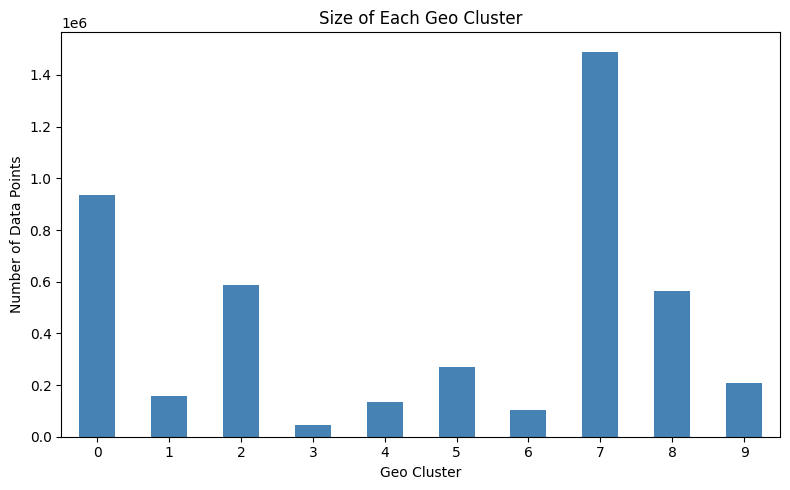

In [23]:
# Count number of points per geo cluster
cluster_sizes = top_combined_data['geo_cluster'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(8, 5))
cluster_sizes.plot(kind='bar', color='steelblue')
plt.xlabel('Geo Cluster')
plt.ylabel('Number of Data Points')
plt.title('Size of Each Geo Cluster')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [24]:
# Saving the dataframe as pickle file
save_path = '../data/processed/top_combined_data_borough.pkl'

# Ensure the folder exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the DataFrame
top_combined_data.to_pickle(save_path)

## 10. Adding weather data for each borough

- Weather data is added to enrich the dataset with environmental context relevant for analysis.
- A single weather station is chosen because it provides complete and consistent data for the desired time period.
- Using one station avoids complications from merging multiple sources with potential time or location mismatches.
- The selected station represents the broader area adequately for the study’s purpose.

In [25]:
# Load the clustered data with the borough information
top_combined_data = pd.read_pickle(save_path)

In [26]:
# Define the date range
start = pd.to_datetime("2014-04-01")
end = pd.to_datetime("2014-09-30")

# Station with available data (Teterboro Airport)
station_id = 'KTEB0'

# Fetch hourly weather data for the station and date range
weather = Hourly(station_id, start, end).fetch().reset_index()

# Prepare weather dataframe
weather = weather[['time', 'temp', 'prcp']].copy()
weather.rename(columns={
    'time': 'messagetimestamp',
    'temp': 'temperature_c',
    'prcp': 'precipitation_mm'
}, inplace=True)

# Ensure timestamps are datetime and sorted
top_combined_data['messagetimestamp'] = pd.to_datetime(top_combined_data['messagetimestamp'])
top_combined_data = top_combined_data.sort_values('messagetimestamp')
weather = weather.sort_values('messagetimestamp')

# Merge_asof on messagetimestamp with backward direction (nearest past hour)
top_combined_data = pd.merge_asof(
    top_combined_data,
    weather,
    on='messagetimestamp',
    direction='backward'
)

# Print number of missing values after merge
print("Missing temperature values:", top_combined_data['temperature_c'].isna().sum())
print("Missing precipitation values:", top_combined_data['precipitation_mm'].isna().sum())

Missing temperature values: 0
Missing precipitation values: 389863


In [27]:
# Fill missing values
# Precipitation missing values are filled with 0 because missing precipitation usually means no rain
top_combined_data['precipitation_mm'] = top_combined_data['precipitation_mm'].fillna(0)

In [28]:
top_combined_data.head(5)

,messagetimestamp,Lat,Lon,Base,UTM_X,UTM_Y,hour,geo_cluster,dominant_borough,temperature_c,precipitation_mm
0,2014-04-01 00:00:00,40.7637,-73.9600,B02598,587777.940478,4.513046e+06,0,2,Manhattan,11.7,0.0
1,2014-04-01 00:00:00,40.7188,-73.9863,B02598,585615.694367,4.508036e+06,0,8,Manhattan,11.7,0.0
2,2014-04-01 00:00:00,40.7215,-73.9952,B02682,584860.571737,4.508327e+06,0,8,Manhattan,11.7,0.0
3,2014-04-01 00:01:00,40.7355,-73.9966,B02617,584724.572854,4.509880e+06,0,0,Manhattan,11.7,0.0
4,2014-04-01 00:02:00,40.7184,-73.9601,B02682,587829.071998,4.508018e+06,0,9,Brooklyn,11.7,0.0


## 11. Saving the cluster dfs for the cluster analysis

In [29]:
# Deleting all the unnecessary columns
top_combined_data = top_combined_data[['messagetimestamp', 'Lat', 'Lon', 'Base', 'geo_cluster', 'dominant_borough','temperature_c','precipitation_mm']]
top_combined_data.head()

,messagetimestamp,Lat,Lon,Base,geo_cluster,dominant_borough,temperature_c,precipitation_mm
0,2014-04-01 00:00:00,40.7637,-73.9600,B02598,2,Manhattan,11.7,0.0
1,2014-04-01 00:00:00,40.7188,-73.9863,B02598,8,Manhattan,11.7,0.0
2,2014-04-01 00:00:00,40.7215,-73.9952,B02682,8,Manhattan,11.7,0.0
3,2014-04-01 00:01:00,40.7355,-73.9966,B02617,0,Manhattan,11.7,0.0
4,2014-04-01 00:02:00,40.7184,-73.9601,B02682,9,Brooklyn,11.7,0.0


In [30]:
# Target directory to save the pickle files
save_dir = "../data/interim"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Get all unique cluster IDs (sorted)
cluster_ids = sorted(top_combined_data["geo_cluster"].unique())

# Save each cluster as a Pickle file
for cluster_id in cluster_ids:
    cluster_df = top_combined_data[top_combined_data["geo_cluster"] == cluster_id]
    
    # Pickle file path
    pkl_path = os.path.join(save_dir, f"cluster_{cluster_id}.pkl")
    
    # Save as Pickle
    cluster_df.to_pickle(pkl_path)

### 11. Preparing the datasets for the Forecasting

In [31]:
# Only 'messagetimestamp' and 'geo_cluster' are retained, as all other columns are not needed 
# for the forecasting task. 
forecast_data = top_combined_data[['messagetimestamp', 'geo_cluster', 'temperature_c','precipitation_mm']].copy()

# The dataset is split by 'geo_cluster' to allow separate forecasting models or analyses 
# to be performed for each spatial cluster.
output_dir = "../data/processed"
os.makedirs(output_dir, exist_ok=True)

for cluster_id, df_cluster in forecast_data.groupby('geo_cluster'):
    output_path = os.path.join(output_dir, f"forecast_cluster_{cluster_id}.csv")
    df_cluster.to_csv(output_path, index=False)
    print(f"Saved: Cluster {cluster_id} → {output_path}")

Saved: Cluster 0 → ../data/processed/forecast_cluster_0.csv
Saved: Cluster 1 → ../data/processed/forecast_cluster_1.csv
Saved: Cluster 2 → ../data/processed/forecast_cluster_2.csv
Saved: Cluster 3 → ../data/processed/forecast_cluster_3.csv
Saved: Cluster 4 → ../data/processed/forecast_cluster_4.csv
Saved: Cluster 5 → ../data/processed/forecast_cluster_5.csv
Saved: Cluster 6 → ../data/processed/forecast_cluster_6.csv
Saved: Cluster 7 → ../data/processed/forecast_cluster_7.csv
Saved: Cluster 8 → ../data/processed/forecast_cluster_8.csv
Saved: Cluster 9 → ../data/processed/forecast_cluster_9.csv
